Import Required Libraries & Dataset

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, BertConfig, BertTokenizer, BertModel

# specify GPU
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [3]:
# check class distribution
df['label'].value_counts(normalize = True)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

Split the Dataset into train / test

In [7]:
# split train dataset into train, validation and test sets

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

print(train_text.shape)
print(temp_text.shape)
print(val_text.shape)
print(test_text.shape)

(3900,)
(1672,)
(836,)
(836,)


Import Bert - base- uncased

In [9]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [10]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

<Axes: >

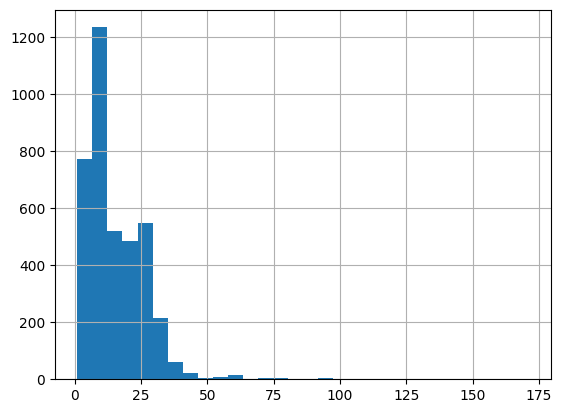

In [11]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

Tokenize & Encode the Sequences

In [12]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

print(len(tokens_train['input_ids']))# 3900 sentences in the training set, that will be divided in 121 batches of size 32 plus 1 last batch of size 28 (see code below)
print(tokens_train.keys())
print(train_text.tolist()[44])
print(tokens_train['input_ids'][44])
print(tokens_train['token_type_ids'][44])
print(tokens_train['attention_mask'][44])

C:\Users\Alienware\miniconda3\envs\py310\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


3900
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Please attend the phone:)
[101, 3531, 5463, 1996, 3042, 1024, 1007, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Test Examples

In [28]:
print("train text:", train_text.tolist()[8])
for key, value in tokens_train.items():
    print( '-\nKEY: {}\nVALUE: {}\nDECODE: {}\nCONVERTtoTOKENS: {}\nLABEL: {}'.
          format(key, value[8], tokenizer.decode(value[8]),tokenizer.convert_ids_to_tokens(value[8]),train_labels.values[8])) 
    
print("----------------")    

similar = ["Sorry, I'lll call later"]
print("similar text:", similar)
token_similar = tokenizer.batch_encode_plus(list(similar), max_length = 25, pad_to_max_length=True, truncation=True) #padding = True
for key, value in token_similar.items():
    print( '-\nKEY: {}\nVALUE: {}\nDECODE: {}\nCONVERTtoTOKENS: {}'.
          format(key, value[0], tokenizer.decode(value[0]),tokenizer.convert_ids_to_tokens(value[0]))) 

print("----------------------------------------------------------------------------------")    

Himalayas = "where is Himalayas in the world map?"
print("Himalayas text:", Himalayas)
token_Himalayas = tokenizer.encode_plus(Himalayas)
for key, value in token_Himalayas.items():
    print( '-\nKEY: {}\nVALUE: {}\nDECODE: {}\nCONVERTtoTOKENS: {}'.
          format(key, value, tokenizer.decode(value),tokenizer.convert_ids_to_tokens(value))) 
    
print("----------------")    

Himalayass = "where is Himalayass in the world map?"
print("Himalayass text:", Himalayass)
token_Himalayass = tokenizer.encode_plus(Himalayass)
for key, value in token_Himalayass.items():
    print( '-\nKEY: {}\nVALUE: {}\nDECODE: {}\nCONVERTtoTOKENS: {}'.
          format(key, value, tokenizer.decode(value),tokenizer.convert_ids_to_tokens(value))) 
    
print("----------------------------------------------------------------------------------")

q1 = 'Who was Tony Stark?'
c1 = 'Anthony Edward Stark known as Tony Stark is a fictional character in Avengers'
print("double text:", q1, c1)
encoding = tokenizer.encode_plus(q1, c1)
for key, value in encoding.items():
    print( '-\nKEY: {}\nVALUE: {}\nDECODE: {}\nCONVERTtoTOKENS: {}'.
          format(key, value, tokenizer.decode(value),tokenizer.convert_ids_to_tokens(value))) 
    

# #another example

# sent_idx = 7
# print("train text:", train_text.tolist()[sent_idx])
# for key, value in tokens_train.items():
#     print( '-\nKEY: {}\nVALUE: {}\nDECODE: {}\nCONVERTtoTOKENS: {}\nLABEL: {}'.
#           format(key, value[sent_idx], tokenizer.decode(value[sent_idx]),tokenizer.convert_ids_to_tokens(value[sent_idx]),test_labels.values[sent_idx]))     
# print('-------------')    
# print(test_seq[sent_idx])
# print(test_ids[sent_idx])
# print(test_mask[sent_idx])
# print(test_y[sent_idx])

train text: Sorry, I'll call later
-
KEY: input_ids
VALUE: [101, 3374, 1010, 1045, 1005, 2222, 2655, 2101, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DECODE: [CLS] sorry, i'll call later [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
CONVERTtoTOKENS: ['[CLS]', 'sorry', ',', 'i', "'", 'll', 'call', 'later', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
LABEL: 0
-
KEY: token_type_ids
VALUE: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DECODE: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
CONVERTtoTOKENS: ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

List to Tensors

In [30]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids']).cuda()
train_ids = torch.tensor(tokens_train['token_type_ids']).cuda()
train_mask = torch.tensor(tokens_train['attention_mask']).cuda()
train_y = torch.tensor(train_labels.tolist()).cuda()

val_seq = torch.tensor(tokens_val['input_ids']).cuda()
val_ids = torch.tensor(tokens_val['token_type_ids']).cuda()
val_mask = torch.tensor(tokens_val['attention_mask']).cuda()
val_y = torch.tensor(val_labels.tolist()).cuda()

test_seq = torch.tensor(tokens_test['input_ids']).cuda()
test_ids = torch.tensor(tokens_test['token_type_ids']).cuda()
test_mask = torch.tensor(tokens_test['attention_mask']).cuda()
test_y = torch.tensor(test_labels.tolist()).cuda()


Data Loader

In [35]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32




# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

#Every DataLoader has a Sampler which is used internally to get the indices for each batch

# sampler for sampling the data during training (shuffled random indexes)
train_sampler = RandomSampler(train_data)
print('iterating over the RandomSampler')
for count, sample in enumerate(train_sampler):
        print('count:', count, 'sample:',sample)
        if (count >= 5):
            break
    
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)




# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during validation (non shuffled sequential indexes)
val_sampler = SequentialSampler(val_data)
print('iterating over the SequentialSampler')
for count, sample in enumerate(val_sampler):
        print('count:', count, 'sample:',sample)
        if (count >= 5):
            break
    
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

print(train_data)
print(train_sampler)
print(train_dataloader)
print(val_data)
print(val_sampler)
print(val_dataloader)



iterating over the RandomSampler
count: 0 sample: 565
count: 1 sample: 3009
count: 2 sample: 1415
count: 3 sample: 1945
count: 4 sample: 47
count: 5 sample: 441
iterating over the SequentialSampler
count: 0 sample: 0
count: 1 sample: 1
count: 2 sample: 2
count: 3 sample: 3
count: 4 sample: 4
count: 5 sample: 5


In [12]:
for ids, mask, label in val_dataloader: #sequential indexes
    print('index:',ids[0],'\nmask:',mask[0],'\nlabel:',label[0])
    break

index: tensor([  101,  2748,  1045,  2318,  2000,  4604, 11186,  2000,  2191,  2009,
         2021,  3255,  2234,  2067,  2061,  1045,  1005,  1049,  2067,  1999,
         2793,  1012,  3313,  7824,   102], device='cuda:0') 
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') 
label: tensor(0, device='cuda:0')


In [13]:
for ids, mask, label in train_dataloader: #shuffled indexes
    print('index:',ids[0],'\nmask:',mask[0],'\nlabel:',label[0])
    break

index: tensor([  101, 10261,  2017,  1037,  3376,  2154,  1012,  2169,  2617,  8669,
         2130,  2062,  2477,  2000,  2562,  2017,  5629,  1012,  2079,  5959,
         2009,  1012,   102,     0,     0], device='cuda:0') 
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0], device='cuda:0') 
label: tensor(0, device='cuda:0')


Model Architecture

In [40]:
# freezing the BERT model parameters. This means that during training, the gradients for these parameters will not be calculated, and thus, they won't be updated, to:
# Reduce Computational Load: Saves memory and speeds up training by not calculating gradients for frozen layers.
# Fine-Tuning Specific Layers: Allows you to train only the new layers added on top of BERT, which can be useful for fine-tuning for a specific task.
# Prevent Overfitting: Helps maintain the pre-trained knowledge of BERT while focusing the training on task-specific parameters.

for param in bert.parameters():
    param.requires_grad = False
    # print(param.shape)

In [41]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512) # 768 because the last bert model layer: (dense): Linear(in_features=768, out_features=768, bias=True)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2) # classification layer for binary classification

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1) 

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [45]:
# pass the pre-trained BERT to our defined architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [43]:
train_seq.device

device(type='cuda', index=0)

In [18]:
# for i in model.parameters():
#     print(i.is_cuda)

In [46]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

C:\Users\Alienware\miniconda3\envs\py310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
from sklearn.utils.class_weight import compute_class_weight

#Class Weights calculated to be reused in the Weighted Cross Entropy formula, for imbalanced dataset

#compute the class weights
class_weights = compute_class_weight(class_weight ='balanced', classes = np.unique(train_labels), y = train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


In [50]:
train_labels.value_counts(normalize=True) # same proportion as the wights above

label
0    0.865897
1    0.134103
Name: proportion, dtype: float64

In [53]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) # Negative Log Likelihood Loss 

# number of training epochs
epochs = 10

Fine-Tune

In [64]:
# function to train the model
def train():
    
    model.train() # To train the model, you should first set it back in training mode with model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 30 batches.
        if step % 30 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch - average per epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [65]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval() # is a kind of switch for some specific layers/parts of the model 
                 # that behave differently during training and inference (evaluating) time. 
                 # For example, Dropouts Layers, BatchNorm Layers etc. 
                 # You need to turn them off during model evaluation, and .eval() will do it for you

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 30 batches.
        if step % 30 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad(): #we don't compute or use gradients during evaluation, so turning off the autograd will speed up execution and will reduce memory usage
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [63]:
# example to illustrate how to process batches of data and gather predictions from the model.

pred_perc_list = []

for step, batch in enumerate(train_dataloader):
    sent_id = batch[0]
    # print(sent_id)
    mask = batch[1]
    # print(mask)
    label = batch[2]
    # print(label)
    
# prediction_percent are in the form of:      no. of batches (122), size of batch (32) , no. of classes (2).
# reshape the predictions_percent in form of: number of samples (3900), no. of classes(2).
    
    pred_perc = model(sent_id, mask) # tensor of 32, as batch size
    pred_perc = pred_perc.detach().cpu().numpy()
    print('batch #', len(pred_perc_list), pred_perc.shape)    
    print(pred_perc)
    pred_perc_list.append(pred_perc)  
    
    if step == 1: # to print only the first two batches
        break    
    
pred_perc_list_reshaped  = np.concatenate(pred_perc_list, axis=0)
print('pred percent list length:',len(pred_perc_list))
print('pred percent list reshaped:', pred_perc_list_reshaped.shape)
# print('last pred perc:', pred_perc.shape, '\n', pred_perc) #last one


batch # 0 (32, 2)
[[-0.7584998  -0.6318047 ]
 [-0.64107037 -0.7480856 ]
 [-0.72417665 -0.6630516 ]
 [-0.71084094 -0.67576104]
 [-0.6884782  -0.697838  ]
 [-0.68326855 -0.70312434]
 [-0.6351935  -0.7546671 ]
 [-0.6140341  -0.779061  ]
 [-0.7230811  -0.66408336]
 [-0.6290417  -0.7616455 ]
 [-0.6610404  -0.72631896]
 [-0.68599796 -0.70034784]
 [-0.6377073  -0.75184196]
 [-0.6925959  -0.69369876]
 [-0.65400964 -0.733879  ]
 [-0.6942425  -0.6920531 ]
 [-0.6677069  -0.7192517 ]
 [-0.7643821  -0.62665105]
 [-0.64556676 -0.74310505]
 [-0.6822188  -0.7041964 ]
 [-0.7000039  -0.6863372 ]
 [-0.5529033  -0.8563184 ]
 [-0.6250542  -0.76621777]
 [-0.6471532  -0.741359  ]
 [-0.6718228  -0.71493626]
 [-0.6901509  -0.69615245]
 [-0.65125465 -0.7368718 ]
 [-0.5769191  -0.82468283]
 [-0.7945112  -0.60111874]
 [-0.65306926 -0.7348987 ]
 [-0.7191669  -0.6677873 ]
 [-0.69064075 -0.6956599 ]]
batch # 1 (32, 2)
[[-0.67733145 -0.70921713]
 [-0.7484579  -0.640736  ]
 [-0.69110745 -0.6951912 ]
 [-0.5280191  -0.8

In [66]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    30  of    122.
  Batch    60  of    122.
  Batch    90  of    122.
  Batch   120  of    122.

Evaluating...

Training Loss: 0.680
Validation Loss: 0.656

 Epoch 2 / 10
  Batch    30  of    122.
  Batch    60  of    122.
  Batch    90  of    122.
  Batch   120  of    122.

Evaluating...

Training Loss: 0.646
Validation Loss: 0.625

 Epoch 3 / 10
  Batch    30  of    122.
  Batch    60  of    122.
  Batch    90  of    122.
  Batch   120  of    122.

Evaluating...

Training Loss: 0.616
Validation Loss: 0.596

 Epoch 4 / 10
  Batch    30  of    122.
  Batch    60  of    122.
  Batch    90  of    122.
  Batch   120  of    122.

Evaluating...

Training Loss: 0.592
Validation Loss: 0.570

 Epoch 5 / 10
  Batch    30  of    122.
  Batch    60  of    122.
  Batch    90  of    122.
  Batch   120  of    122.

Evaluating...

Training Loss: 0.569
Validation Loss: 0.545

 Epoch 6 / 10
  Batch    30  of    122.
  Batch    60  of    122.
  Batch    90  of    122.
  Batch   12

In [67]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Make predictions

In [68]:
# get predictions for test data
with torch.no_grad(): #no gradients computation needed
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [69]:
# model's performance
test_y = test_y.detach().cpu().numpy()
preds_01 = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds_01))

print(type(test_y))
print(type(preds_01))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       724
           1       0.50      0.80      0.62       112

    accuracy                           0.87       836
   macro avg       0.73      0.84      0.77       836
weighted avg       0.90      0.87      0.88       836

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
